In [11]:
import ee
ee.Authenticate()

True

In [12]:
ee.Initialize()

In [29]:
#colección de imágenes de tipos de superficie
suelo = ee.ImageCollection ("MODIS/061/MCD12Q1")
#colección de imágenes de temperatura superficial
temp = ee.ImageCollection('MODIS/061/MOD11A1')
#imagen de elevación
elev = ee.Image("USGS/SRTMGL1_003")

In [39]:
inicio = "2020-01-01"
fin = "2024-01-01"
temp = temp.select("LST_Day_1km", "QC_Day").filterDate(inicio, fin)

In [40]:
urb = ee.Geometry.Point(-100.31, 25.72)
rur = ee.Geometry.Point(-100.44, 25.92)

In [41]:
scale = 1000  # los datos son en kilómetros, cambiemos a metros

# imprimir elevaciones (primer dato del arreglo)
elev_urb = elev.sample(urb, scale).first().get('elevation').getInfo()
elev_rur = elev.sample(rur, scale).first().get('elevation').getInfo()
print('Elevación en el punto urbano:', elev_urb, 'm')
print('Elevación en el punto rural:', elev_rur, 'm')

# imprimir el tipo de suelo
suelo_urb = suelo.first().sample(urb, scale).first().get('LC_Type1').getInfo()
suelo_rur = suelo.first().sample(rur, scale).first().get('LC_Type1').getInfo()
print('Tipo de suelo en el punto urbano:', suelo_urb)
print('Tipo de suelo en el punto rural:', suelo_rur)

Elevación en el punto urbano: 522 m
Elevación en el punto rural: 1276 m
Tipo de suelo en el punto urbano: 13
Tipo de suelo en el punto rural: 9


In [42]:
# calcular la temperatura promedio en ambos puntos
temp_urb = temp.mean().sample(urb, scale).first().get('LST_Day_1km').getInfo()
temp_rur = temp.mean().sample(rur, scale).first().get('LST_Day_1km').getInfo()
print('Temperatura promedio en el punto urbano durante el día:', round(temp_urb*0.02 -273.15, 2), '°C')
print('Temperatura promedio en el punto rural durante el día:', round(temp_rur*0.02 -273.15, 2), '°C')

Temperatura promedio en el punto urbano durante el día: 36.39 °C
Temperatura promedio en el punto rural durante el día: 28.38 °C


In [43]:
#tomamos datos por regiones
temp_urb_dat = temp.getRegion(urb, scale).getInfo()
temp_rur_dat = temp.getRegion(rur, scale).getInfo()
#imprimir las primeras líneas de datos
print('datos urbanos', temp_urb_dat[:5])
print('datos rurales', temp_rur_dat[:5])

datos urbanos [['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'], ['2020_01_01', -100.31037620120637, 25.723258160762498, 1577836800000, None, 2], ['2020_01_02', -100.31037620120637, 25.723258160762498, 1577923200000, 14875, 145], ['2020_01_03', -100.31037620120637, 25.723258160762498, 1578009600000, None, 2], ['2020_01_04', -100.31037620120637, 25.723258160762498, 1578096000000, 14892, 81]]
datos rurales [['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'], ['2020_01_01', -100.4361403409831, 25.920887523268792, 1577836800000, None, 2], ['2020_01_02', -100.4361403409831, 25.920887523268792, 1577923200000, 14310, 65], ['2020_01_03', -100.4361403409831, 25.920887523268792, 1578009600000, 14391, 65], ['2020_01_04', -100.4361403409831, 25.920887523268792, 1578096000000, 14484, 0]]


In [45]:
import pandas as pd
def ee_arr_dataframe(arr, bandas):
    """transforma un arreglo en un dataframe"""
    df = pd.DataFrame(arr)
    #establecemos los encabezados como fila cero
    encab = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=encab)
    #quitamos los datos nulos
    df = df[['longitude', 'latitude', 'time', *bandas]].dropna()
    #convertimos los datos a valores numéricos
    for banda in bandas:
        df[banda] = pd.to_numeric(df[banda], errors='coerce')
    #convertimos el tiempo en una fecha
    df['datetime'] = pd.to_datetime(df['time'], unit= 'ms')
    df = df[['time', 'datetime', *bandas]]
    return df

In [46]:
def t_cel(t):
    """Convierte la temperatura a Celsius"""
    t_c = 0.02*t - 273.15
    return t_c

In [47]:
df_temp_urb = ee_arr_dataframe(temp_urb_dat, ['LST_Day_1km'])
df_temp_urb['LST_Day_1km'] =df_temp_urb['LST_Day_1km'].apply(t_cel)
df_temp_rur = ee_arr_dataframe(temp_rur_dat, ['LST_Day_1km'])
df_temp_rur['LST_Day_1km'] =df_temp_rur['LST_Day_1km'].apply(t_cel)
df_temp_urb.head()

,time,datetime,LST_Day_1km
1,1577923200000,2020-01-02,24.35
3,1578096000000,2020-01-04,24.69
4,1578182400000,2020-01-05,25.11
5,1578268800000,2020-01-06,28.01
6,1578355200000,2020-01-07,25.01


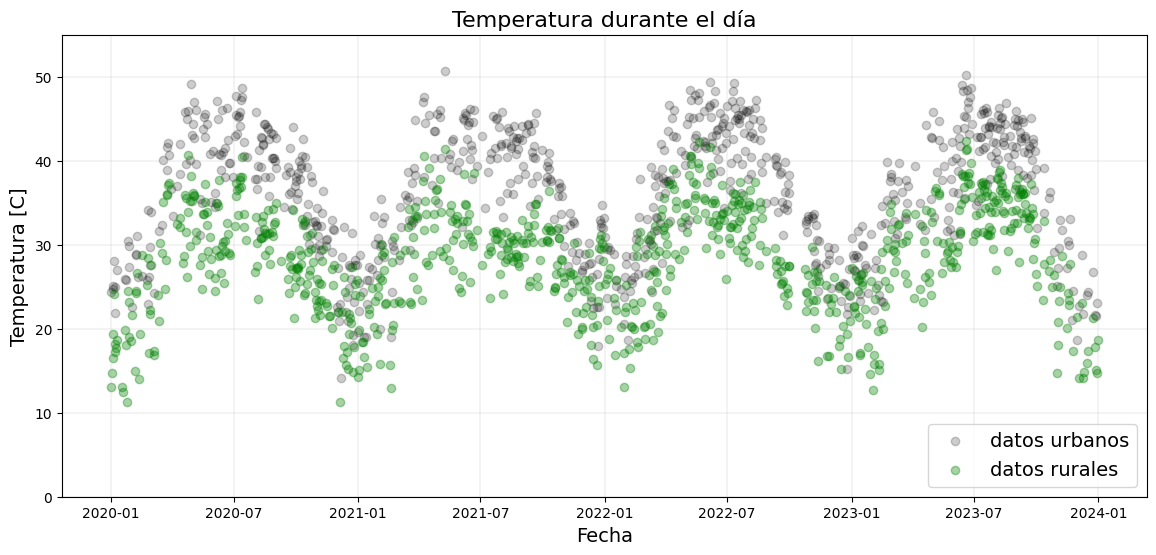

In [48]:
import matplotlib.pyplot as plt
import numpy as np
#seleccionemos los valores del eje horizontal
x_data_u = np.asanyarray(df_temp_urb['time'].apply(float))  # urban
x_data_r = np.asanyarray(df_temp_rur['time'].apply(float))  # rural
#seleccionemos los valores del eje vertical
y_data_u = np.asanyarray(df_temp_urb['LST_Day_1km'].apply(float))  #urban
y_data_r = np.asanyarray(df_temp_rur['LST_Day_1km'].apply(float))  #rural
# establezcamos los subplots
fig, ax = plt.subplots(figsize=(14, 6))
# agreguemos las gráficas de dispersión
ax.scatter(df_temp_urb['datetime'], df_temp_urb['LST_Day_1km'], c='black', alpha=0.2, label='datos urbanos')
ax.scatter(df_temp_rur['datetime'], df_temp_rur['LST_Day_1km'], c='green', alpha=0.35, label='datos rurales')
# parámetros de graficación
ax.set_title('Temperatura durante el día', fontsize=16)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Temperatura [C]', fontsize=14)
ax.set_ylim(-0, 55)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')
plt.show()